In [26]:
import random

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely import geometry,wkt
from geovoronoi import voronoi_regions_from_coords

# Functions

In [ ]:
def generate_random_points(n, lat_min, lat_max, lon_min, lon_max):
    points = []
    for _ in range(n):
        lat = random.uniform(lat_min, lat_max)
        lon = random.uniform(lon_min, lon_max)
        points.append((lat, lon))
    return points

# Calculating Voronois

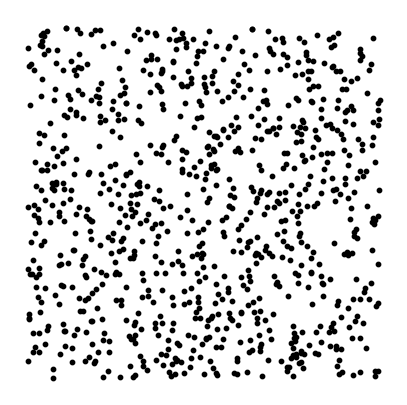

In [84]:
"""
Example scenario witih N points over space
"""
n_points = 900
lat_min, lat_max = 48.8, 48.91  
lon_min, lon_max = 2.2, 2.5

random_points = generate_random_points(n_points, lat_min, lat_max, lon_min, lon_max)
df_bs_locations = pd.DataFrame(random_points,columns=['lat','lon'])

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(df_bs_locations['lon'], df_bs_locations['lat'], s=10,color='black')
ax.axis('off')
plt.show()

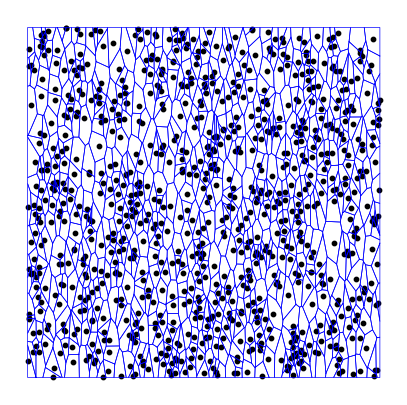

In [85]:
"""
Calculatin the voronois
"""
lat_point_list = [lat_min, lat_max, lat_max, lat_min]
lon_point_list = [lon_min, lon_min, lon_max, lon_max]
boundary_box = geometry.Polygon(zip(lon_point_list, lat_point_list))
coords = np.array((df_bs_locations['lon'],df_bs_locations['lat'])).T

voronois, pts = voronoi_regions_from_coords(coords,boundary_box)

# Organizing these geometries into the original dataframe
df_bs_locations['geometry'] = None
for i in range(0,len(pts)):
    for j in range(0,len(pts[i])):
        df_bs_locations.loc[pts[i][j],'geometry'] = voronois[i]
        
df_bs_locations = gpd.GeoDataFrame(df_bs_locations,crs="EPSG:4326") # These are generated as WGS84; it's good to convert to a better CRS in case there's a need to calculate area

# Plotting
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(df_bs_locations['lon'], df_bs_locations['lat'], s=10,color='black')
for row in df_bs_locations.iterrows():
    ax.plot(row[1]['geometry'].exterior.xy[0],row[1]['geometry'].exterior.xy[1],color='blue',lw=0.5)
ax.axis('off')
plt.show()

# Bounding Voronois to geometries (e.g., Paris)

In [86]:
communes = gpd.read_file('data/region_dep_comune.shp')
paris = communes.loc[communes.insee=='75056'].reset_index(drop=True)

In [92]:
df_bs_locations['in_paris'] = df_bs_locations['geometry'].apply(lambda x: paris.geometry.intersects(x)[0])

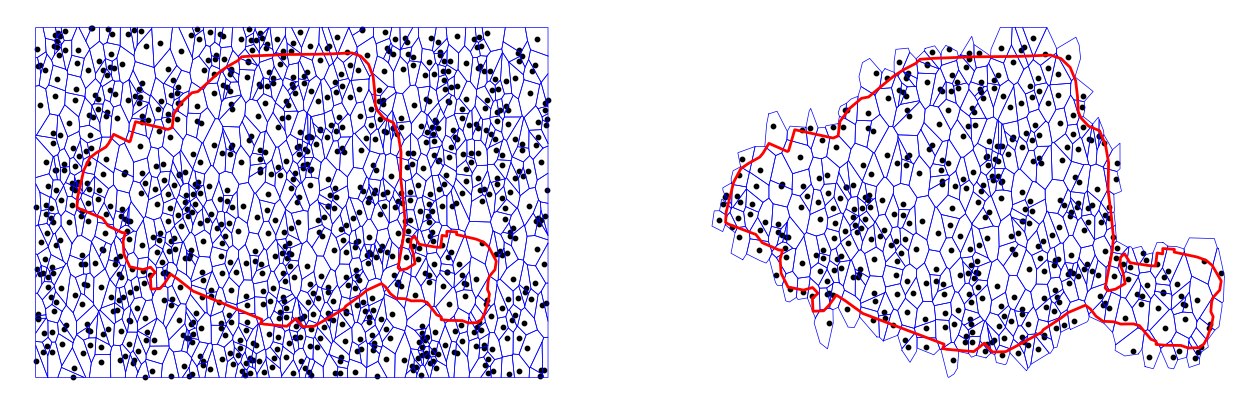

In [93]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].scatter(df_bs_locations['lon'], df_bs_locations['lat'], s=10,color='black')
for row in df_bs_locations.iterrows():
    ax[0].plot(row[1]['geometry'].exterior.xy[0],row[1]['geometry'].exterior.xy[1],color='blue',lw=0.5)
ax[0].plot(paris.geometry[0].exterior.xy[0],paris.geometry[0].exterior.xy[1],color='red',lw=2)

df_bs_paris = df_bs_locations.loc[df_bs_locations.in_paris]
ax[1].scatter(df_bs_paris['lon'], df_bs_paris['lat'], s=10,color='black')
for row in df_bs_paris.iterrows():
    ax[1].plot(row[1]['geometry'].exterior.xy[0],row[1]['geometry'].exterior.xy[1],color='blue',lw=0.5)
ax[1].plot(paris.geometry[0].exterior.xy[0],paris.geometry[0].exterior.xy[1],color='red',lw=2)

ax[0].axis('off')
ax[1].axis('off')
plt.show()

The problem is that these geomemtries would look ugly in a map, and not fully draw the idea of the map of the city. So what we want is to bound them within the shape of Paris

Important to note that this is for visualization only. For calculating traffic and overlaps with other geometries for later analysis, we should keep the original Voronois as they are

In [97]:
df_paris_bs = df_bs_locations.loc[df_bs_locations.in_paris]
df_paris_bs = gpd.overlay(df_paris_bs,paris,how='intersection')

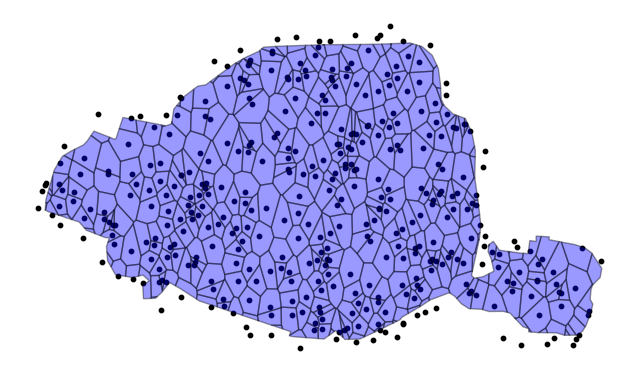

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(df_paris_bs['lon'], df_paris_bs['lat'], s=10, color='black')
df_paris_bs.plot(ax=ax, color='blue', alpha=0.4, edgecolor='black')

ax.axis('off')
plt.show()